In [1]:
from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/drive', force_remount=True)

unset HISTFILE; export PS1="root@02b7c36a26d3-29dcd3c0ed1749369822185906165924: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@02b7c36a26d3-29dcd3c0ed1749369822185906165924: umount -f /content/drive || umount /content/drive; pkill -9 -x drive
root@02b7c36a26d3-29dcd3c0ed1749369822185906165924: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@02b7c36a26d3-29dcd3c0ed1749369822185906165924: ( while `sleep 0.5`; do if [[ -d "/content/drive" && "$(ls -A /content/drive)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 10411
root@02b7c36a26d3-29dcd3c0ed1749369822185906165924: cat /tmp/tmpf7uct33m/drive.fifo | head -1 | ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task_instances:10,opendir_timeout_ms:120000,virtual_folders_omit_spaces:true --inet_family=IPV4_ONLY --preferences

In [2]:
# ! cat /proc/meminfo

In [3]:
import os
os.chdir('./drive/MyDrive/python_project/dacon_hand')

In [4]:
# ! unzip ./new_open.zip -d ./open

In [5]:
# 데이터 보기
import pandas as pd
import numpy as np
from glob import glob

# 이미지데이터 로딩
from PIL import Image
import cv2
from tqdm import tqdm

# 파일경로 설정
import os
import shutil
import json

# Modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential, load_model
from keras.callbacks import Callback
from keras import backend as K

# GPU 환경 설정
import os
import gc
from keras import backend as k

# Others
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import math

In [6]:
data_path = './open'

train_path = data_path + '/train'
test_path = data_path + '/test'
crop_train_path = data_path + '/crop_train2'
crop_test_path = data_path + '/crop_test2'

hand_gesture = pd.read_csv(data_path + '/hand_gesture_pose.csv')
sample_submission = pd.read_csv(data_path + '/sample_submission.csv')

In [7]:
# Train 데이터에 있는 폴더를 glob로 불러와
# sorted method를 통해 숫자 순으로 정렬합니다.
train_folders = sorted(glob(train_path + '/*'), key = lambda x : int(x.split('/')[-1]))
test_folders  = sorted(glob(test_path + '/*'), key = lambda x : int(x.split('/')[-1]))
crop_train_folders = sorted(glob(crop_train_path + '/*'), key = lambda x : int(x.split('/')[-1]))
crop_test_folders  = sorted(glob(crop_test_path + '/*'), key = lambda x : int(x.split('/')[-1]))
train_folders[:5]

['./open/train/0',
 './open/train/1',
 './open/train/2',
 './open/train/3',
 './open/train/4']

In [8]:
train_folder = train_folders[0]
crop_train_folder = crop_train_folders[0]

image_paths = sorted(glob(crop_train_folder + '/*.png'), key = lambda x : int(x.split('/')[-1].replace('.png','')))
json_path   = glob(train_folder + '/*.json')[0]

In [9]:
image_paths

['./open/crop_train2/0/0.png',
 './open/crop_train2/0/1.png',
 './open/crop_train2/0/2.png',
 './open/crop_train2/0/3.png',
 './open/crop_train2/0/4.png',
 './open/crop_train2/0/5.png',
 './open/crop_train2/0/6.png',
 './open/crop_train2/0/7.png',
 './open/crop_train2/0/8.png']

(692, 602, 3)


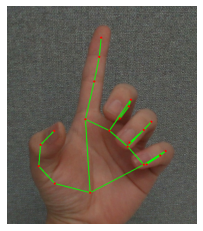

In [10]:
image_path = image_paths[0]
img = Image.open(image_path)
img_arr = np.array(img)
print(img_arr.shape)
plt.imshow(img_arr)
plt.axis('off')
plt.show()

In [11]:
js = json.load(open(json_path))

print("json keys              : ", js.keys())

print("json action info       : ",js.get('action'))

print("json actor info        : ",js.get('actor'))

print("json annotations keys  : ",js.get('annotations')[0].keys())

json keys              :  dict_keys(['action', 'actor', 'id', 'annotations'])
json action info       :  [0, '숫자 1']
json actor info        :  None
json annotations keys  :  dict_keys(['image_id', 'data'])


In [12]:
# answers = []
# for train_folder in train_folders :
#     json_path = glob(train_folder + '/*.json')[0]
#     js = json.load(open(json_path))
#     cat = js.get('action')[0]  # 수정
#     cat_name = js.get('action')[1]  # 수정
#     answers.append([train_folder.replace(data_path,''),cat, cat_name])

# answers = pd.DataFrame(answers, columns = ['train_path','answer', 'answer_name'])
# answers

In [13]:
# answers.to_csv('./answers.csv', index=False)

In [14]:
answers = pd.read_csv('./answers.csv')
answers

,train_path,answer,answer_name
0,/train/0,0,숫자 1
1,/train/1,0,숫자 1
2,/train/2,10,숫자 1
3,/train/3,10,숫자 1
4,/train/4,10,숫자 1
...,...,...,...
644,/train/644,194,빅토리
645,/train/645,195,부정(엄지손 아래로)
646,/train/646,195,부정(엄지손 아래로)
647,/train/647,195,부정(엄지손 아래로)


In [15]:
classes = pd.get_dummies(answers[['answer']], columns = ['answer']).to_numpy()

In [16]:
classes.shape

(649, 157)

In [17]:
np.random.shuffle(crop_train_folders) # 일반화 가능성 높이기

In [18]:
image_size = 224

In [19]:
# images  = []
# targets = []
# for train_folder in tqdm(crop_train_folders) :
#     image_paths = sorted(glob(train_folder + '/*.png'), key = lambda x : int(x.split('/')[-1].replace('.png','')))
#     query_path  = train_folder.replace(data_path,'')
#     target = classes[int(train_folder.split('/')[-1])] 
#     for image_path in image_paths:
#         img = image.load_img(image_path, target_size=(image_size,image_size,3))
#         img = image.img_to_array(img)
#         img = img/255
#         images.append(img)
#         targets.append(target)

In [20]:
# np.save('./crop_img_380', np.array(images))
# np.save('./crop_targets_380', np.array(targets))

In [21]:
images = np.load('./crop_img2.npy')
targets = np.load('./crop_targets2.npy')

In [22]:
X = images
print('Train X Shape : ', X.shape)

y = targets
print('Train y Shape : ', y.shape)


Train X Shape :  (5887, 224, 224, 3)
Train y Shape :  (5887, 157)


In [23]:
del images
del targets

In [24]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100

In [25]:
num_classes = classes.shape[1]
print(num_classes)
input_shape = (image_size, image_size, 3)

157


In [26]:
! pip install -U tensorflow-addons
import tensorflow_addons as tfa

In [27]:
!pip install --quiet vit-keras
from vit_keras import vit

In [28]:
! pip install adabelief_tf 
from adabelief_tf import AdaBeliefOptimizer

In [29]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
                rotation_range = 10,
                width_shift_range=0.15,
                height_shift_range=0.15,
                # brightness_range=[0.8,1.0]
                # shear_range=0.05,
                # zoom_range=0.05
            )

valgen = ImageDataGenerator(
        )

In [30]:
def vit_model():
    
    model = Sequential()
    model.add(vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = False,
        include_top = False,
        pretrained_top = False,
        classes = num_classes))
    
    model.add(Flatten())
    model.add(BatchNormalization())
    # model.add(Dense(256, activation = tfa.activations.gelu))
    # model.add(Dropout(0.2))
    model.add(Dense(128, activation = tfa.activations.gelu))
    model.add(BatchNormalization())
    model.add(Dense(32, activation = tfa.activations.gelu))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation = "softmax"))


    return model

In [31]:
max_rate = 1e-3
min_rate = 1e-4
cycle = 10

In [32]:
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, n_epochs, lr_max, lr_min, n_cycle, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.n_epochs = n_epochs
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.n_cycle = n_cycle
        self.lrates = list()
        self.verbose = verbose
        
    def cosine_annealing(self, epoch):
        
        epochs_per_cycle = math.floor(self.n_epochs/self.n_cycle)
        cos_inner = (math.pi * (epoch % (epochs_per_cycle))) / (epochs_per_cycle)
        
        return (self.lr_max - self.lr_min)/2 * (tf.math.cos(cos_inner) + 1) + self.lr_min
     
    def plot(self, epoch):
        lr = self.cosine_annealing(epoch)
        self.lrates.append(lr)
        
    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.cosine_annealing(epoch)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose == 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))
            
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

------------------------------------------------------------------------
Training for fold 3 ...
Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.1)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.



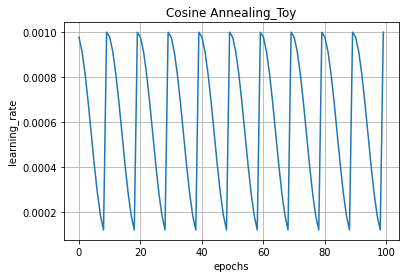

Epoch 1/100

Epoch 00001: CosineAnnealingScheduler setting learning rate to tf.Tensor(0.0009999999, shape=(), dtype=float32).
147/147 [==============================] - 192s 873ms/step - loss: 5.1687 - accuracy: 0.0071 - top-5-accuracy: 0.0378 - val_loss: 5.2308 - val_accuracy: 0.0170 - val_top-5-accuracy: 0.0527
Epoch 2/100

Epoch 00002: CosineAnnealingScheduler setting learning rate to tf.Tensor(0.0009779754, shape=(), dtype=float32).
147/147 [==============================] - 126s 858ms/step - loss: 5.0296 - accuracy: 0.0128 - top-5-accuracy: 0.0596 - val_loss: 5.3083 - val_accuracy: 0.0042 - val_top-5-accuracy: 0.0680
Epoch 3/100

Epoch 00003: CosineAnnealingScheduler setting learning rate to tf.Tensor(0.0009140576, shape=(), dtype=float32).
100/147 [===================>..........] - ETA: 37s - loss: 4.7734 - accuracy: 0.0293 - top-5-accuracy: 0.1002

KeyboardInterrupt: ignored

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import EfficientNetB0


# kfold = KFold(n_splits=5, shuffle=True)
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

fold_no = 1
for e , (train, val) in  enumerate(skf.split(X, np.argmax(y, axis=1))):

    if fold_no in [3, 4, 5]:
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # modelpath = "./vit_model/vit_aug_{epoch:02d}-{val_loss:.4f}_fold:%d.hdf5" % fold_no
        checkpoint = ModelCheckpoint('./vit_model'+f'/check{e}_vit_b16.h5',save_best_only=True)
        early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)
        
        AdaBelief = AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-8, weight_decay=1e-2)
        cosine_scheduler = CosineAnnealingScheduler(num_epochs, max_rate, min_rate, cycle)

        train_x = X[train]
        train_y = y[train]
        valid_x = X[val]
        valid_y = y[val]

        model = vit_model()

        model.compile(
            optimizer=AdaBelief,
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=[
                tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
                tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ],
        )


        for i in range(1, num_epochs + 1):
            cosine_scheduler.plot(i)

        plt.plot(cosine_scheduler.lrates)
        plt.title('Cosine Annealing_Toy')
        plt.xlabel('epochs'); plt.ylabel('learning_rate')
        plt.grid()
        plt.show()
        

        training_generator = datagen.flow(train_x, train_y, batch_size=batch_size, seed=77, shuffle=True)
        validation_generator = valgen.flow(valid_x, valid_y, batch_size=batch_size, seed=77, shuffle=True)
        history = model.fit(
            training_generator,
            shuffle=True,
            steps_per_epoch =len(train_x)//batch_size,
            epochs=num_epochs,
            validation_data=validation_generator,
            callbacks=[checkpoint, early_stopping_callback,cosine_scheduler]
        )

        del train_x
        del train_y
        del valid_x
        del valid_y

        gc.collect()
        k.clear_session()

    fold_no += 1


In [ ]:
# model_name1 = 'vit_aug_30-0.0134_fold:1.hdf5'
# model1 = load_model('./vit_model/%s' % model_name1, custom_objects={'AdaBeliefOptimizer' : AdaBeliefOptimizer})
# model_name2 = 'vit_aug_29-0.0082_fold:2.hdf5'
# model2 = load_model('./vit_model/%s' % model_name2, custom_objects={'AdaBeliefOptimizer' : AdaBeliefOptimizer})
# model_name3 = 'vit_aug_28-0.0183_fold:3.hdf5'
# model3 = load_model('./vit_model/%s' % model_name3, custom_objects={'AdaBeliefOptimizer' : AdaBeliefOptimizer})
# model_name4 = 'vit_aug_20-0.0139_fold:4.hdf5'
# model4 = load_model('./vit_model/%s' % model_name4, custom_objects={'AdaBeliefOptimizer' : AdaBeliefOptimizer})
# model_name5 = 'vit_aug_27-0.0074_fold:5.hdf5'
# model5 = load_model('./vit_model/%s' % model_name5, custom_objects={'AdaBeliefOptimizer' : AdaBeliefOptimizer})

In [ ]:
# from tensorflow.keras.preprocessing import image
# test_images  = []
# for test_folder in tqdm(crop_test_folders) :
#     image_paths = sorted(glob(test_folder + '/*.png'), key = lambda x : int(x.split('/')[-1].replace('.png','')))
#     query_path  = test_folder.replace(data_path,'')
#     test_image = []
#     for image_path in image_paths:
#         img = image.load_img(image_path, target_size=(image_size,image_size,3))
#         img = image.img_to_array(img)
#         img = img/255
#         test_image.append(img)
#     test_images.append(test_image)

# test_images = np.array(test_images)
# print(test_images.shape)

In [ ]:
# np.save('./crop_test_images_300', np.array(test_images))

In [ ]:
test_images = np.load('./crop_test_images2.npy',allow_pickle=True)
print(test_images.shape)

In [ ]:
print(np.array(test_images.shape))

In [ ]:
np.array(test_images[0]).shape

In [ ]:
# all_model = [model1, model2, model3, model4, model5]

In [ ]:
import time
start = time.time()  # 시작 시간 저장

sub=np.zeros((test_images.shape[0], num_classes))  

for e in range(5):

    model = vit_model()
    model.load_weights('./vit_model'+f'/check{e}_vit_b16.h5')

    predictions = []
    for test_image in tqdm(test_images, total = len(test_images)) : 
        prediction = np.mean(model.predict(np.array(test_image)), axis = 0)
        predictions.append(prediction)

    sub+=predictions

mean_sub = sub/5
mean_sub

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

In [ ]:
# import time
# start = time.time()  # 시작 시간 저장

# sub=np.zeros((test_images.shape[0], num_classes))  

# e = 1
# model = vit_model()
# model.load_weights('./vit_model'+f'/check{e}_vit_b16.h5')

# predictions = []
# for test_image in tqdm(test_images, total = len(test_images)) : 
#     prediction = np.mean(model.predict(np.array(test_image)), axis = 0)
#     predictions.append(prediction)

# sub+=predictions

# print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

In [ ]:
predictions_label = []
for i in mean_sub:

    predictions_label.append(np.argmax(i))

In [ ]:
sample_submission.iloc[:,1:] = mean_sub
display(sample_submission.head())
sample_submission.to_csv('./submit/vit16_kfold_5_aug_(5).csv', index=False)

In [ ]:
predictions_label